## Neo4j

> pip install neo4j  
> pip install networkx  

In [1]:
from datetime import datetime
print(datetime.now().strftime('%F %X'))
from pprint import pprint
from importlib.metadata import version
import sys
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt

print(sys.version)
print('neo4j =', version('neo4j'))
print('networkx =', version('networkx'))

2026-02-14 10:32:41
3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
neo4j = 6.1.0
networkx = 3.6.1


In [2]:
# 接続設定
URI = 'bolt://localhost:7687'
AUTH = ('neo4j', 'neo4jpassword')
DATABASE_NAME = 'neo4j'

### データの追加

In [3]:
def add_friend(tx, name1, name2):
    # クエリ：2人の人物ノードを作成し、FRIEND関係で結ぶ
    query = """
    MERGE (a:Person {name: $name1})
    MERGE (b:Person {name: $name2})
    MERGE (a)-[:FRIEND]->(b)
    RETURN a, b
    """
    tx.run(query, name1=name1, name2=name2)

# 2. ドライバの作成と実行
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    # 接続確認（認証エラーがあればここで止まります）
    driver.verify_connectivity()
    
    with driver.session(database=DATABASE_NAME) as session:
        # データの書き込み実行
        session.execute_write(add_friend, "Alice", "Bob")
        print("データの書き込みが完了しました！")

データの書き込みが完了しました！


In [4]:
def get_friends(tx):
    # すべてのPersonノードと、そのFRIEND関係にある相手を取得するクエリ
    query = """
    MATCH (p1:Person)-[:FRIEND]->(p2:Person)
    RETURN p1.name AS person, p2.name AS friend
    """
    result = tx.run(query)
    # 結果をリスト形式で返す
    return [record.data() for record in result]

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    with driver.session(database=DATABASE_NAME) as session:
        # 読み取りの実行
        friends_list = session.execute_read(get_friends)
        
        print("--- 取得したデータ ---")
        for record in friends_list:
            print(f"{record['person']} は {record['friend']} と友達です")

--- 取得したデータ ---
Alice は Bob と友達です


### データの表示

In [5]:
def dump_all_simple(tx):
    # ノード(n)、リレーションのタイプ(rel_type)、相手ノード(m)を明確に取得
    query = """
    MATCH (n)
    OPTIONAL MATCH (n)-[r]->(m)
    RETURN n, type(r) as rel_type, m
    """
    # .data()を使って、扱いやすい辞書リストとして返す
    return [record.data() for record in tx.run(query)]

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    with driver.session(database=DATABASE_NAME) as session:
        data_list = session.execute_read(dump_all_simple)
        
        print(f"--- 全データダンプ (計 {len(data_list)} 行) ---")
        
        for row in data_list:
            # 始点ノード
            node_n = row['n']
            name_n = node_n.get('name', '名無し') # nameプロパティがない場合の対策
            labels_n = list(node_n.keys()) # プロパティキーを表示(簡易的)
            
            # リレーションがある場合
            if row['rel_type']:
                rel_name = row['rel_type']
                node_m = row['m']
                name_m = node_m.get('name', '名無し')
                print(f"[{name_n}] --[{rel_name}]--> [{name_m}]")
            
            # リレーションがない場合（孤立ノード）
            else:
                print(f"[{name_n}] (つながりなし)")

--- 全データダンプ (計 2 行) ---
[Alice] --[FRIEND]--> [Bob]
[Bob] (つながりなし)


### データの描画

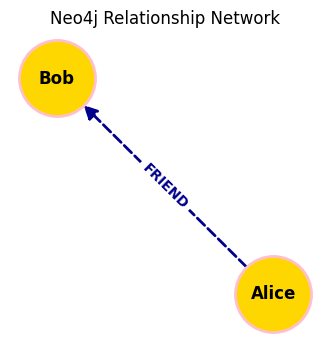

In [6]:
def get_graph_data(tx):
    # 全てのノードとリレーションを取得
    query = "MATCH (n)-[r]->(m) RETURN n.name AS source, m.name AS target, type(r) AS rel"
    return list(tx.run(query))

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    with driver.session() as session:
        results = session.execute_read(get_graph_data)

# --- 可視化の処理 ---
G = nx.DiGraph()  # 指向性グラフを作成

for res in results:
    G.add_edge(res['source'], res['target'], label=res['rel'])

# ノード、リレーションの設定（スプリングレイアウトが一般的）
pos = nx.spring_layout(G, k=1.0)                 # kでノード間の距離を調整
edge_labels = nx.get_edge_attributes(G, 'label')

# 描画
fig, ax = plt.subplots(figsize=(4, 4))
ax.margins(0.15)

# ノードとラベルの描画
nx.draw(
    G, pos, 
    with_labels=True, node_color='gold', node_size=3000, 
    linewidths=2, edgecolors='pink', 
    font_size=12, font_weight='bold', 
    arrowsize=20, 
    edge_color='darkblue', width=2, style='dashed'
)

# エッジ（線）のラベル表示
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=edge_labels, 
    label_pos=0.5, font_color='darkblue', 
    font_size=10, font_weight='bold'
)

ax.set_title('Neo4j Relationship Network')
plt.show()

### データの削除

In [7]:
def del_all(tx):
    # クエリ：2人の人物ノードを作成し、FRIEND関係で結ぶ
    query = """
    MATCH (n) DETACH DELETE n
    """
    tx.run(query)

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    # 接続確認（認証エラーがあればここで止まります）
    driver.verify_connectivity()
    
    with driver.session(database=DATABASE_NAME) as session:
        # データの書き込み実行
        session.execute_write(del_all)
        print("すべてのデータの削除が完了しました！")

すべてのデータの削除が完了しました！
